In [29]:
from Model import Levels, ElectronsTransitionsData, AtomsTransitionsData, PickAndSolve, UFloat, utilities
import numpy as np
import pandas as pd
from Model.utilities import n_, s_
from tqdm.auto import tqdm
from PlotUtils.saveToCsv import saveToCsv, getNextFilename

from PlotUtils import errsPlot as plt, splt

from scipy.optimize import curve_fit

splt.set_export_folder(".")

In [2]:
n_g = 2.687e25
T_g = 300

real_value = {
    'T_e' : 2,
    'f_e' : 10**-5
}

In [3]:
data = pd.read_csv('exports/SimulatedData.csv', index_col = False).to_dict('list')

data['density'] = [ UFloat.UFloat( n, s ) for n, s in zip( data['density_n'], data['density_s'] ) ]
data['label_idx'] = Levels.Levels().namesToIdxs( data['label'] )

Initializing class Levels


In [4]:
# Loading data from a previous broad characterization
filename = 'results/r003_z001'

prev = pd.read_csv( filename + '.csv', index_col = False )

f_es = np.unique( prev['f_es'].to_numpy() )
T_es = np.unique( prev['T_es'].to_numpy() )
chisquared = prev['chisquared'].to_numpy().reshape( ( len( f_es ), len( T_es ) ) )

In [12]:
richi = np.max( 1 / chisquared ) - 1/chisquared

In [45]:
# Spot the interesting area as below 90% of the chi squared
richi_f_e = np.min( richi, axis = 1 )
richi_T_e = np.min( richi, axis = 0 )

richi_f_e_idx = np.where( richi_f_e < np.max( richi_f_e ) * 0.1 )
richi_T_e_idx = np.where( richi_T_e < np.max( richi_T_e ) * 0.1 )

f_e_min_idx = np.argmin( richi_f_e )
T_e_min_idx = np.argmin( richi_T_e )

f_e_lims = (lambda a: (np.min(a), np.max(a)+1))(richi_f_e_idx)
T_e_lims = (lambda a: (np.min(a), np.max(a)+1))(richi_T_e_idx)
while( f_e_lims[1] - f_e_lims[0] < 5 ):
    f_e_lims[0] -= 1
    f_e_lims[1] += 1
while( T_e_lims[1] - T_e_lims[0] < 5 ):
    T_e_lims[0] -= 1
    T_e_lims[1] += 1

f_e_lmdt = f_es[ f_e_lims[0]:f_e_lims[1] ]
T_e_lmdt = T_es[ T_e_lims[0]:T_e_lims[1] ]
richi_lmtd = richi[ f_e_lims[0]:f_e_lims[1], T_e_lims[0]:T_e_lims[1] ]
f_e_cent = f_e_lmdt - f_es[f_e_min_idx]
T_e_cent = T_e_lmdt - T_es[T_e_min_idx]

In [58]:
def secondorder( dd, x0, fxx, fyy, fxy ):
    return [ x0 + 0.5 * ( fxx * d[0] * d[0] + fyy * d[1] * d[1] + 2 * fxy * d[0] * d[1] ) for d in dd ]
xs, ys = np.meshgrid( f_e_cent, T_e_cent )
xsys = list( zip( xs.flatten(),ys.flatten() ) )
z = richi_lmtd.T.flatten()
popt, _ = curve_fit( secondorder, xsys, z )
print( popt )

errors = np.sqrt( np.diag( np.linalg.inv( np.array( [[ popt[1], popt[3] ], [ popt[3], popt[2] ]]) ) ) )

popt

[6.19284726e-05 2.81794774e+08 7.64152651e-03 1.46186735e+03]


array([6.19284726e-05, 2.81794774e+08, 7.64152651e-03, 1.46186735e+03])

In [62]:
np.polyfit( f_e_cent, richi[f_e_lims[0]:f_e_lims[1],T_e_min_idx], 2 )

array([ 1.84570566e+08, -2.78952447e+01,  1.59416316e-05])

In [64]:
np.polyfit( T_e_cent, richi[f_e_min_idx,T_e_lims[0]:T_e_lims[1]], 2 )

array([ 6.12190897e-03, -2.14852658e-04,  6.75428784e-06])

In [65]:
print( np.array( [[ popt[1], popt[3] ], [ popt[3], popt[2] ]] ) )
print( np.array( [[ 1.84570566e+08, 0 ], [ 0, 6.12190897e-03 ]] ) )

[[2.81794774e+08 1.46186735e+03]
 [1.46186735e+03 7.64152651e-03]]
[[1.84570566e+08 0.00000000e+00]
 [0.00000000e+00 6.12190897e-03]]


In [67]:
 print( np.linalg.inv( np.array( [[ popt[1], popt[3] ], [ popt[3], popt[2] ]] ) ) )
 print( np.linalg.inv( np.array( [[ 1.84570566e+08, 0 ], [ 0, 6.12190897e-03 ]] ) )  )

[[ 4.69206258e-07 -8.97618178e-02]
 [-8.97618178e-02  1.73028087e+04]]
[[5.41798198e-09 0.00000000e+00]
 [0.00000000e+00 1.63347741e+02]]


In [68]:
 print( np.sqrt( np.diag( np.linalg.inv( np.array( [[ popt[1], popt[3] ], [ popt[3], popt[2] ]] ) ) ) ) )
 print( np.sqrt( np.diag( np.linalg.inv( np.array( [[ 1.84570566e+08, 0 ], [ 0, 6.12190897e-03 ]] ) )  ) ) )

[6.84986319e-04 1.31540141e+02]
[7.36069424e-05 1.27807567e+01]


In [55]:
print( "f_e: ", f_es[f_e_min_idx], " +/- ", errors[0] )
print( "T_e: ", T_es[T_e_min_idx], " +/- ", errors[1] )

f_e:  1.06829626010026e-05  +/-  0.000684986319296368
T_e:  1.8518733720160307  +/-  131.54014092044417


Text(0, 0.5, 'Section of chisquared at optimal f_e')

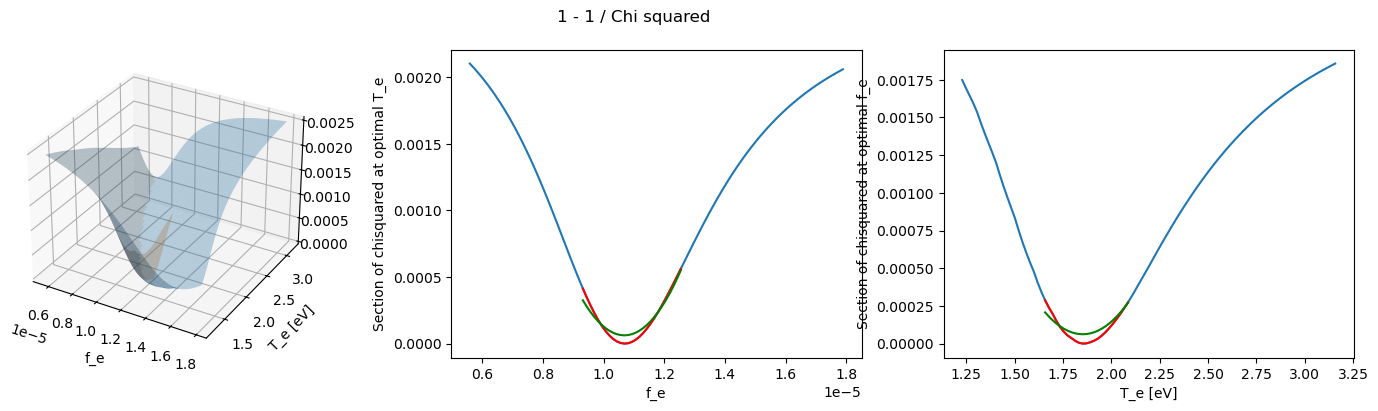

In [ ]:
ax = plt.figure( figsize = ( 18, 4 ) ).add_subplot(1, 3, 1, projection='3d')

ax.plot_surface( *np.meshgrid(f_es,  T_es), richi.T, alpha=0.3 )
ax.plot_surface( *np.meshgrid(f_e_lmdt,  T_e_lmdt), richi_lmtd.T, alpha=0.3, color='tab:orange' )

plt.xlabel("f_e")
plt.ylabel("T_e [eV]")

plt.suptitle("1 - 1 / Chi squared")

# splt.export( filename + "_1OverChisquared_3d" )

ax = plt.gcf().add_subplot( 1, 3, 2 )
plt.plot( f_es, richi[:,T_e_min_idx] )
plt.plot( f_e_lmdt, richi[f_e_lims[0]:f_e_lims[1],T_e_min_idx], 'r' )
plt.plot( f_e_lmdt, secondorder( list( zip( f_e_cent, np.zeros( len(f_e_cent) ) )), *popt), 'g' )
# plt.plot( real_value['f_e'], 1 / real_value['chi2'], 'ro' )
# plt.plot( result['f_e'], 1 / result['chi2'], 'go' )

plt.xlabel("f_e")
plt.ylabel("Section of chisquared at optimal T_e")

ax = plt.gcf().add_subplot( 1, 3, 3 )
plt.plot( T_es, richi[f_e_min_idx,:] )
plt.plot( T_e_lmdt, richi[f_e_min_idx,T_e_lims[0]:T_e_lims[1]], 'r' )
plt.plot( T_e_lmdt, secondorder( list( zip( np.zeros( len(T_e_lmdt) ), T_e_cent )), *popt), 'g' )
# plt.plot( real_value['T_e'], 1 / real_value['chi2'], 'ro' )
# plt.plot( result['T_e'], 1 / result['chi2'], 'go' )

plt.xlabel("T_e [eV]")
plt.ylabel("Section of chisquared at optimal f_e")


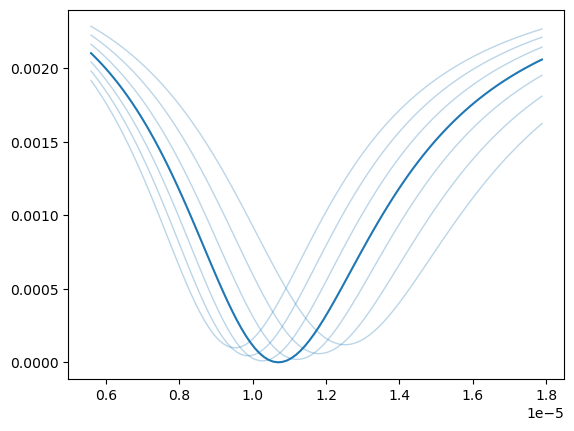

In [75]:
plt.plot( f_es, richi[:,T_e_min_idx] )
for i in [5, 10, 15]:
    plt.plot( f_es, richi[:,T_e_min_idx+i], lw = 1, alpha = 0.3, c='tab:blue' )
    plt.plot( f_es, richi[:,T_e_min_idx-i], lw = 1, alpha = 0.3, c='tab:blue' )

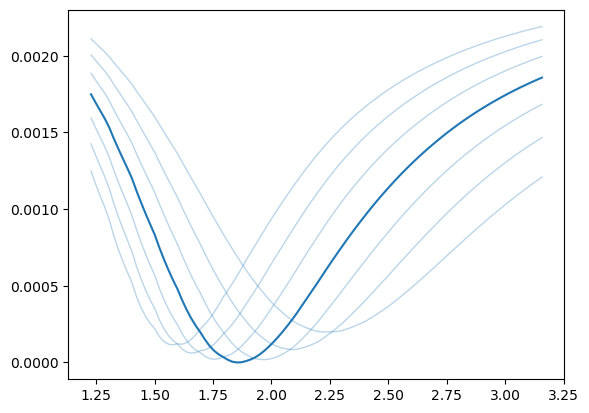

In [76]:
plt.plot( T_es, richi[f_e_min_idx,:] )
for i in [5, 10, 15]:
    plt.plot( T_es, richi[f_e_min_idx+i,:], lw = 1, alpha = 0.3, c='tab:blue' )
    plt.plot( T_es, richi[f_e_min_idx-i,:], lw = 1, alpha = 0.3, c='tab:blue' )